# Mushroom classification
In this notebook I'll be comparing different ML models and its accuracy in simple image classification task. Dataset consist of 9 different classes of mushrooms.

In [2]:
import plotting
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from NetUtils import NetUtils
util = NetUtils()
plt.style.use('ggplot')

## Preparing the data

In [3]:
def create_dir(directory):
    if os.path.exists(directory):
        return
    os.mkdir(directory)

def copy_file(src_path, dst_path, file):
    src = os.path.join(src_path, file)
    dst = os.path.join(dst_path, file)
    shutil.copy(src, dst)

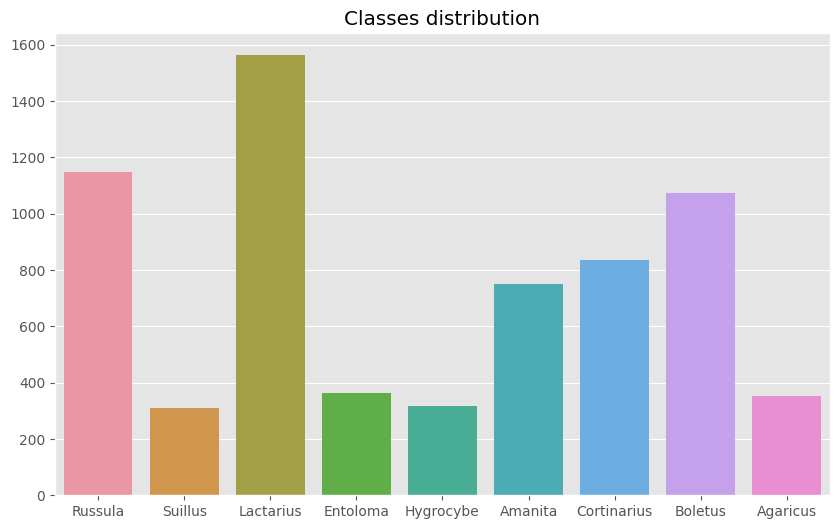

In [4]:
dataset_dir = 'Mushrooms'
classes = os.listdir(dataset_dir)
x = []
y = []
for cl in classes:
    class_length = len(os.listdir(f'{dataset_dir}/{cl}'))
    x.append(cl)
    y.append(class_length)
plt.figure(figsize=(10,6))
sns.barplot(x=x, y=y)
plt.title("Classes distribution")
plt.show()

As we can see we need to deal with imbalanced data here. 
<!-- (Therefore let's use class weighting technique.)-->

In [5]:
base_dir = 'mushrooms'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

create_dir(base_dir)
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)

for parent_dir in [train_dir, test_dir, val_dir]:
    for cl in classes:
        create_dir(f'{parent_dir}/{cl}')

In [6]:
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1
train_samples = 0
val_samples = 0
test_samples = 0

In [7]:
for cl in classes:
    img_directories = os.listdir(f'{dataset_dir}/{cl}')    
    
    class_length = len(img_directories)
    train_length = int(train_percentage * class_length)
    val_length = int(val_percentage * class_length)
    test_length = class_length - train_length - val_length
    
    train_samples += train_length
    val_samples += val_length
    test_samples += test_length
    
    src = f'{dataset_dir}/{cl}'
    dst = f'{train_dir}/{cl}'
    for img in img_directories[:train_length]: # TRAIN
        copy_file(src, dst, img)
    
    dst = f'{val_dir}/{cl}'
    for img in img_directories[train_length : train_length+val_length]: # VALIDATION
        copy_file(src, dst, img)
        
    dst = f'{test_dir}/{cl}'
    for img in img_directories[train_length+val_length:]: # TEST
        copy_file(src, dst, img)

## Parameters configuration

In [8]:
BATCH_SIZE = 32
TRAIN_DATASET_LEN = train_samples
VAL_DATASET_LEN = val_samples
TEST_DATASET_LEN = train_samples
STEPS_PER_EPOCH = TRAIN_DATASET_LEN // BATCH_SIZE
VALIDATION_STEPS = VAL_DATASET_LEN // BATCH_SIZE
EPOCHS = 20
NUM_CLASSES = 9

## Simple CNN model

In [9]:
from SimpleCNN import SimpleCNN
cnn = SimpleCNN(input_shape=(150,150,3), num_classes=NUM_CLASSES)
cnn.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE, data_augm=True)
cnn.create_callbacks('cnn.h5')

Found 5367 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 679 images belonging to 9 classes.


In [ ]:
history = cnn.train(steps_per_epoch=STEPS_PER_EPOCH,
                         epochs=EPOCHS,
                         validation_steps=VALIDATION_STEPS)

In [ ]:
cnn.clf_report()

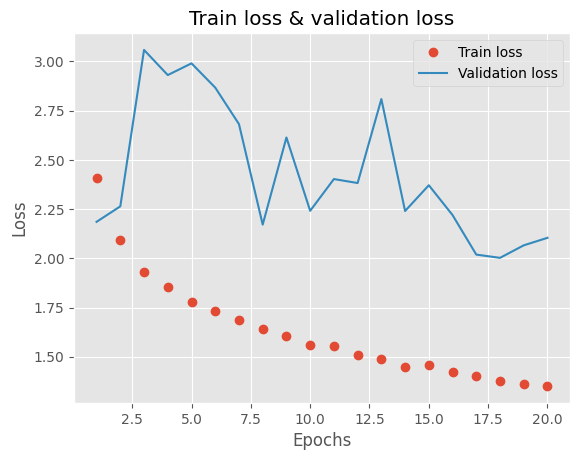

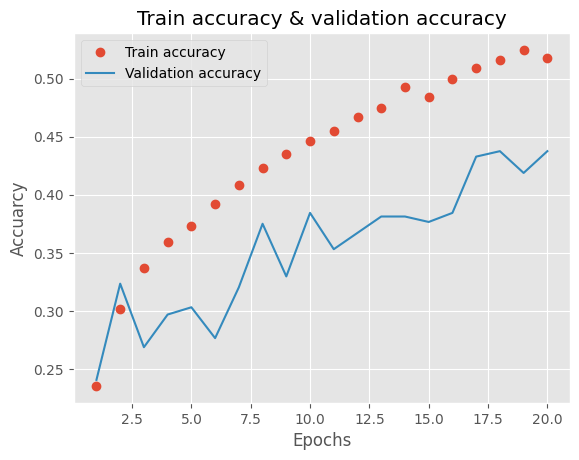

In [12]:
plotting.loss_plot(history.history)
plotting.acc_plot(history.history)

## VGG16

In [13]:
from VGG import VGG
vgg = VGG(input_shape=(150,150,3), num_classes=NUM_CLASSES,load_weights='vgg16.h5')
vgg.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE, data_augm=True)
vgg.create_callbacks('vgg16_.h5')

Found 5367 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 679 images belonging to 9 classes.


In [ ]:
history = vgg.train(steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=EPOCHS,
                   validation_steps=VALIDATION_STEPS)

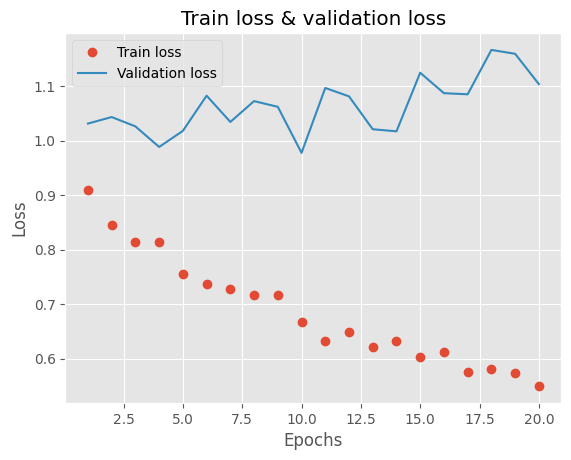

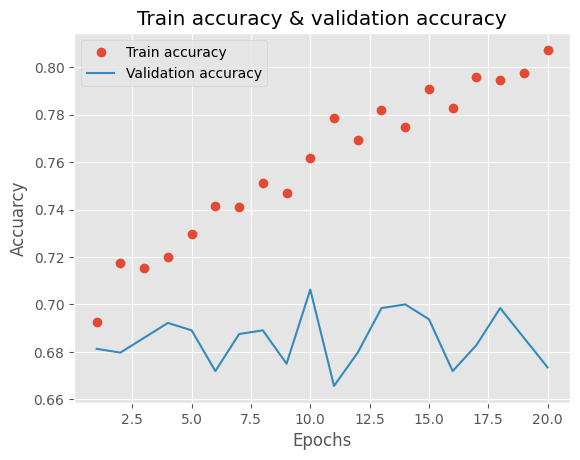

In [15]:
plotting.loss_plot(history.history)
plotting.acc_plot(history.history)

## MobileNet

In [16]:
from MobileNet import MobileNet

mobilenet = MobileNet(input_shape=(150,150,3), num_classes=NUM_CLASSES)
mobilenet.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE)
mobilenet.create_callbacks('mobilenet.h5')

Found 5367 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 679 images belonging to 9 classes.


In [ ]:
history = mobilenet.train(steps_per_epoch=STEPS_PER_EPOCH,
               epochs=EPOCHS,
               validation_steps=VALIDATION_STEPS)

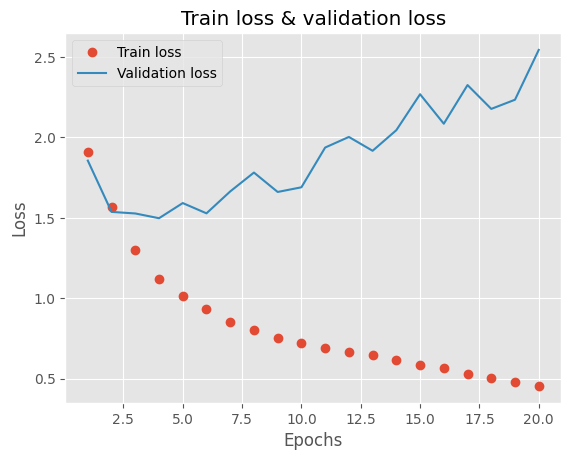

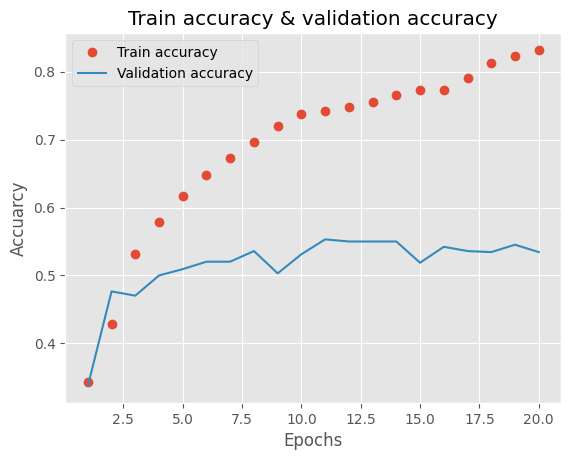

In [18]:
plotting.loss_plot(history.history)
plotting.acc_plot(history.history)

## Resnet50

In [ ]:
from ResNet import ResNet
resnet = ResNet(input_shape=(150,150,3), num_classes=NUM_CLASSES, load_weights='resnet.h5')
resnet.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE)
resnet.create_callbacks('resnet_.h5')
history = resnet.train(steps_per_epoch=STEPS_PER_EPOCH,
                       epochs=EPOCHS,
                       validation_steps=VALIDATION_STEPS)

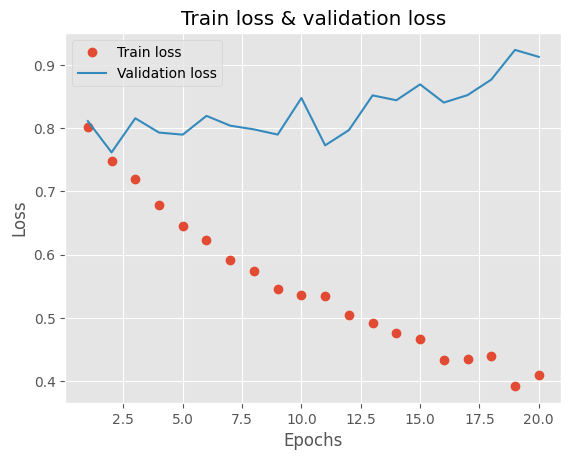

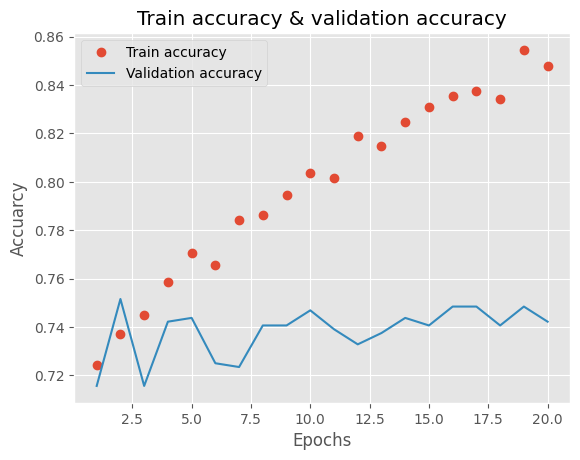

In [24]:
plotting.loss_plot(history.history)
plotting.acc_plot(history.history)

## EfficientNetB7

In [26]:
from EfficientNet import EfficientNet
effnet = EfficientNet(input_shape=(150,150,3), num_classes=NUM_CLASSES)
effnet.create_generators(train_dir, val_dir, test_dir, batch_size=BATCH_SIZE)
#effnet.create_callbacks('effnet.h5') # Does not work with callbacks - bug
effnet.summary()

Found 5367 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 679 images belonging to 9 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 dense_13 (Dense)            (None, 64)                163904    
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_12 (Bat  (None, 32)               128       
 chNormalization)                                             

In [ ]:
history = effnet.train(steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_steps=VALIDATION_STEPS)

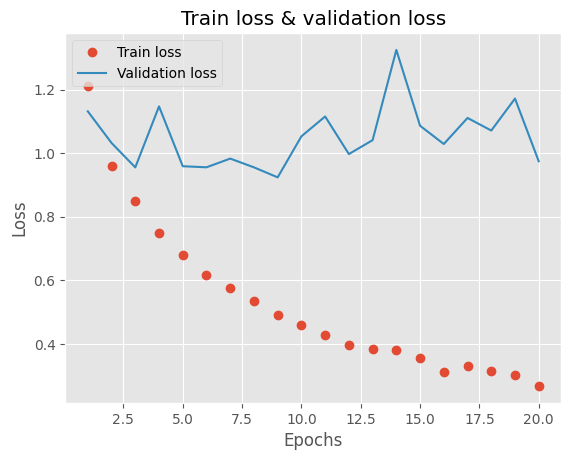

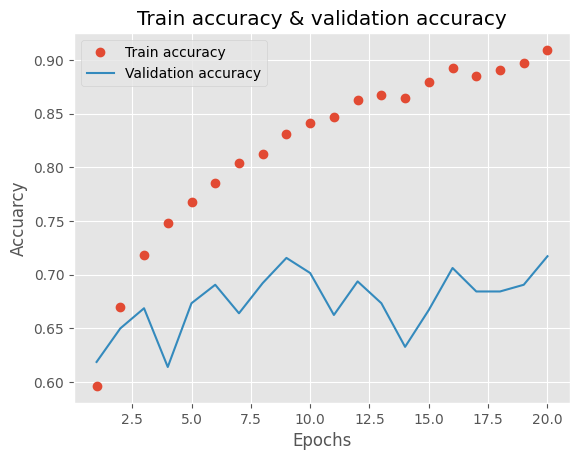

In [29]:
plotting.loss_plot(history.history)
plotting.acc_plot(history.history)